In [1]:
import numpy as np
import pandas as pd

In [33]:
path = 'M:/My Documents/Business/Property/Statements/processed/'

def strip(df):
    df['Memo']=df['Memo'].str.strip()
    df['Subcategory']=df['Subcategory'].str.strip()
    if 'Description' in df.columns:
        df['Description']=df['Description'].str.strip()
    return df

def load(spreadsheets):
    dfIv = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo','Property','Description'])
    dfMt = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo','Property','Description'])
    df40 = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo'])
    for spreadsheet in spreadsheets:
        dfMtTemp=load_worksheet(spreadsheet, 'MT')
        dfMt=pd.concat([dfMt,dfMtTemp]) 
        dfIvTemp=load_worksheet(spreadsheet, 'IV')
        dfIv=pd.concat([dfIv,dfIvTemp])
        df40Temp=load_worksheet(spreadsheet, 'IV (4040)')
        df40=pd.concat([df40,df40Temp]) 
    dfMt=strip(dfMt)
    dfIv=strip(dfIv)
    df40=strip(df40)
    
    dfMt=dfMt.loc[:, ~dfMt.columns.str.contains('^Unnamed')]
    dfIv=dfIv.loc[:, ~dfIv.columns.str.contains('^Unnamed')]
    df40=df40.loc[:, ~df40.columns.str.contains('^Unnamed')]
    
    dfMt=dfMt.set_index('Date')
    dfIv=dfIv.set_index('Date')
    df40=df40.set_index('Date')
    return dfMt, dfIv, df40

def load_worksheet(spreadsheet, worksheet):
    input_file = path + spreadsheet + '.xlsm'
    df = pd.read_excel(input_file,sheet_name=worksheet)
    df.drop('Import', axis=1, inplace=True)
    df.drop('Number', axis=1, inplace=True)
    df = df.astype({"Description": str})
    df = df[~df.Account.isnull()]
    return df

def categorise(df):
    # Categorise expenses
    # Mortgage, PropertyExpense, OurRent, BealsRent, ServiceCharge
    # SchoolFees, Car, Hilltop, PersonalExpenses, RegularPayment
    global dfUncat
    df["Cat"] = np.nan
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('JASPER|TOPAZ|SIBERITE|MORTGAGE EXPRESS|NRAM|PLATFORM|AMBER|BHAM|CAPITAL|CHL|MORTGAGE TRUST')==True),"Cat"] = 'Mortgage'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*M TUCKER.*STO.*')==True) & (df.Amount > -200) & (df.Amount <-190),"Cat"] = 'Mortgage' # Kingston Rd mortgage
    df.loc[(df.Cat.isnull())&(df.Description.notnull())&(df.Description.str.match('Rent for period')==True),"Cat"] = 'OurRent'
    df.loc[(df.Cat.isnull())&(df.Description.notnull())&(df.Property.notnull()) & (df.Description.str.match('Rent for period')==False),"Cat"] = 'PropertyExpense'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('BEALS.*BGC')==True),"Cat"] = 'BealsRent'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('23 HAMPSHIRE.*STO|4-6 ALHAMBRA RD CS|12-14 ALHAMBRA RD|16-18 ALHAMBRA RD|ALHAMBRA ROAD MANA')==True),"Cat"] = 'ServiceCharge'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*HARPUR TRUST.*|.*BEDFORD SCHOOL.*')==True),"Cat"] = 'SchoolFee'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*F VALENTINO.*')==True),"Cat"] = 'Hilltop'
    
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT')&(df.Memo.str.match('HMRC')==True),"Cat"] = 'HMRC'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT')&(df.Memo.str.match('CCTV|Letterbox',case=False)==True),"Cat"] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT'),"Cat"] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CASH'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CRE'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='OTH'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='BCC'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='REFUND'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CHQ'),'Cat'] = 'PersonalExpense'

    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*INTERCO.*',case=False)==True),'Cat'] = 'ServiceCharge'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Description.str.match('.*Alham.*|.*HAG.*',case=False)==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*13438023.*|.*83672832.*|.*23534332.*|.*13686035.*')==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*Alham.*|.*HAG.*',case=False)==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*63796884.*|.*33631583.*',case=False)==True),'Cat'] = 'ServiceCharge'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*LAND ROVER.*')==True),"Cat"] = 'Car'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='DIRECTDEBIT'),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('NATIONWIDE|KINGSTON UNITY')==True),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='REPEATPMT')&(df.Memo.str.match('.*M TUCKER.*STO.*')==True)&(df.Amount>-100),'Cat'] = 'RegularPayment'

    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('Sofia|Rocco', case=False)==True),'Cat'] = 'Kids'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*30728691.*')==True),'Cat'] = 'Funds3072'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*40406538 .*')==True),'Cat'] = 'Funds4040'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*60458872.*')==True),'Cat'] = 'Funds6045'

    df.loc[(df.Cat.isnull())&(df.Amount>0),'Cat'] = 'OtherIncome'
    df.loc[(df.Cat.isnull())&(df.Amount<0),'Cat'] = 'OtherExpense'

    return df

def sumOf(df,cat):
    g=pd.Grouper(freq="M")
    return df.loc[df.Cat == cat,'Amount'].groupby(g).sum()

def get_pty_summary(dfMt,dfIv):
    dfPty = pd.DataFrame()
    dfPty['Mortgage']=pd.concat([sumOf(dfMt,'Mortgage'),sumOf(dfIv,'Mortgage')],axis=1).sum(axis=1)
    dfPty['PropertyExpense']=pd.concat([sumOf(dfMt,'PropertyExpense'),sumOf(dfIv,'PropertyExpense')],axis=1).sum(axis=1)
    dfPty['ServiceCharge']=pd.concat([sumOf(dfMt,'ServiceCharge'),sumOf(dfIv,'ServiceCharge')],axis=1).sum(axis=1)
    dfPty['OurRent']=pd.concat([sumOf(dfMt,'OurRent'),sumOf(dfIv,'OurRent')],axis=1).sum(axis=1)
    dfPty['BealsRent']=pd.concat([sumOf(dfMt,'BealsRent'),sumOf(dfIv,'BealsRent')],axis=1).sum(axis=1)
    dfPty['TotalRent']=dfPty['OurRent'] + dfPty['BealsRent']
    dfPty['NetProfit']=dfPty['OurRent'] + dfPty['BealsRent'] + dfPty['Mortgage'] + dfPty['PropertyExpense'] + dfPty['ServiceCharge']
    return dfPty

def get_outgoings(dfPty,dfMt,dfIv,df40):
    dfOut = pd.DataFrame()
    dfOut['NetProfit']=dfPty['NetProfit']
    dfOut['SchoolFee']=pd.concat([sumOf(dfMt,'SchoolFee'),sumOf(dfIv,'SchoolFee'),sumOf(df40,'SchoolFee')],axis=1).sum(axis=1)
    dfOut['Hilltop']=pd.concat([sumOf(dfMt,'Hilltop'),sumOf(dfIv,'Hilltop'),sumOf(df40,'Hilltop')],axis=1).sum(axis=1)
    dfOut['Car']=pd.concat([sumOf(dfMt,'Car'),sumOf(dfIv,'Car'),sumOf(df40,'Car')],axis=1).sum(axis=1)
    dfOut['RegularPayment']=pd.concat([sumOf(dfMt,'RegularPayment'),sumOf(dfIv,'RegularPayment'),sumOf(df40,'RegularPayment')],axis=1).sum(axis=1)
    dfOut['PersonalExpense']=pd.concat([sumOf(dfMt,'PersonalExpense'),sumOf(dfIv,'PersonalExpense'),sumOf(df40,'PersonalExpense')],axis=1).sum(axis=1)
    dfOut['Other']=pd.concat([sumOf(dfMt,'OtherIncome'),sumOf(dfIv,'OtherIncome'),sumOf(df40,'OtherIncome')],axis=1).sum(axis=1) + \
                   pd.concat([sumOf(dfMt,'OtherExpense'),sumOf(dfIv,'OtherExpense'),sumOf(df40,'OtherExpense')],axis=1).sum(axis=1)    
    dfOut['TotalOutgoings']=dfOut['SchoolFee'] + dfOut['Car'] + dfOut['Hilltop'] + dfOut['PersonalExpense'] + dfOut['RegularPayment']
    dfOut['Profit']=dfPty['NetProfit']+dfOut['TotalOutgoings']
    dfOut['Other']=dfOut['Other'].fillna(0)
    return dfOut
    
# add subcats for pie chart - food, home, fast food etc

In [34]:
spreadsheets=[ \
              'Beals_RentalStatement_JUN2019_08082019_2041', 'Beals_RentalStatement_JUL2019_12102019_2048', \
              'Beals_RentalStatement_AUG2019_12102019_2049', 'Beals_RentalStatement_SEP2019_01122019_2054', \
              'Beals_RentalStatement_OCT2019_05042020_2058', 'Beals_RentalStatement_NOV2019_05042020_2059', \
              'Beals_RentalStatement_DEC2019_05042020_2061', 'Beals_RentalStatement_JAN2020_05042020_2063', \
              'Beals_RentalStatement_FEB2020_05042020_2065', 'Beals_RentalStatement_MAR2020_20082020_2066', \
              'Beals_RentalStatement_APR2020_21082020_2071', 'Beals_RentalStatement_MAY2020_28082020_2082', \
              'Beals_RentalStatement_JUN2020_28082020_2083', 'Beals_RentalStatement_JUL2020_28082020_2084', \
              'Beals_RentalStatement_AUG2020_23062021_2098', 'Beals_RentalStatement_SEP2020_23062021_2105', \
              'Beals_RentalStatement_OCT2020_23062021_2109', 'Beals_RentalStatement_NOV2020_23062021_2124', \
              'Beals_RentalStatement_DEC2020_23062021_2125']

dfMt, dfIv, df40 = load(spreadsheets)
dfIv=categorise(dfIv)
dfMt=categorise(dfMt)
df40=categorise(df40)

C:\Users\MSTDTP21\.conda\envs\mtpython36\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()
C:\Users\MSTDTP21\.conda\envs\mtpython36\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [35]:
dfPty=get_pty_summary(dfMt,dfIv)
dfPty

,Mortgage,PropertyExpense,ServiceCharge,OurRent,BealsRent,TotalRent,NetProfit
Date,,,,,,,
2019-06-30,-9533.85,-11883.63,-1200.00,1300.00,16245.72,17545.72,-5071.76
2019-07-31,-9818.50,-8379.45,-1200.00,1650.00,17527.97,19177.97,-219.98
2019-08-31,-9676.15,-2163.38,-1200.00,1795.00,16870.98,18665.98,5626.45
2019-09-30,-9666.54,-1981.00,-1200.00,2570.00,15647.84,18217.84,5370.30
2019-10-31,-9666.54,-13870.99,-1200.00,16876.00,12000.77,28876.77,4139.24
2019-11-30,-9666.54,-3729.56,-1200.00,5320.00,12150.70,17470.70,2874.60
2019-12-31,-9673.06,-3786.32,-1200.00,10010.00,10649.83,20659.83,6000.45
2020-01-31,-9675.33,-6230.28,-1200.00,14459.51,11293.74,25753.25,8647.64
2020-02-29,-9532.86,-3650.24,-1200.00,7370.00,10892.95,18262.95,3879.85


In [36]:
dfOut=get_outgoings(dfPty,dfMt,dfIv,df40)
dfOut

,NetProfit,SchoolFee,Hilltop,Car,RegularPayment,PersonalExpense,Other,TotalOutgoings,Profit
Date,,,,,,,,,
2019-06-30,-5071.76,-2637.40,-102.0,-476.44,-681.34,-6993.92,0.00,-10891.10,-15962.86
2019-07-31,-219.98,-4433.06,-102.0,-476.44,-886.47,-3201.12,0.00,-9099.09,-9319.07
2019-08-31,5626.45,0.00,-902.0,-476.44,-755.59,-2453.78,0.00,-4587.81,1038.64
2019-09-30,5370.30,-10264.84,-102.0,-476.44,-853.38,-2139.88,10231.84,-13836.54,-8466.24
2019-10-31,4139.24,-2381.50,-102.0,-476.44,-871.87,-2194.93,-960.82,-6026.74,-1887.50
2019-11-30,2874.60,-1280.75,-102.0,-476.44,-647.09,-2765.86,980.00,-5272.14,-2397.54
2019-12-31,6000.45,0.00,-302.0,-476.44,-744.53,-2848.44,-401.87,-4371.41,1629.04
2020-01-31,8647.64,-11453.53,-102.0,-476.44,-800.12,-2441.68,9243.94,-15273.77,-6626.13
2020-02-29,3879.85,-4624.22,-102.0,-476.44,-651.45,-2320.18,7376.65,-8174.29,-4294.44


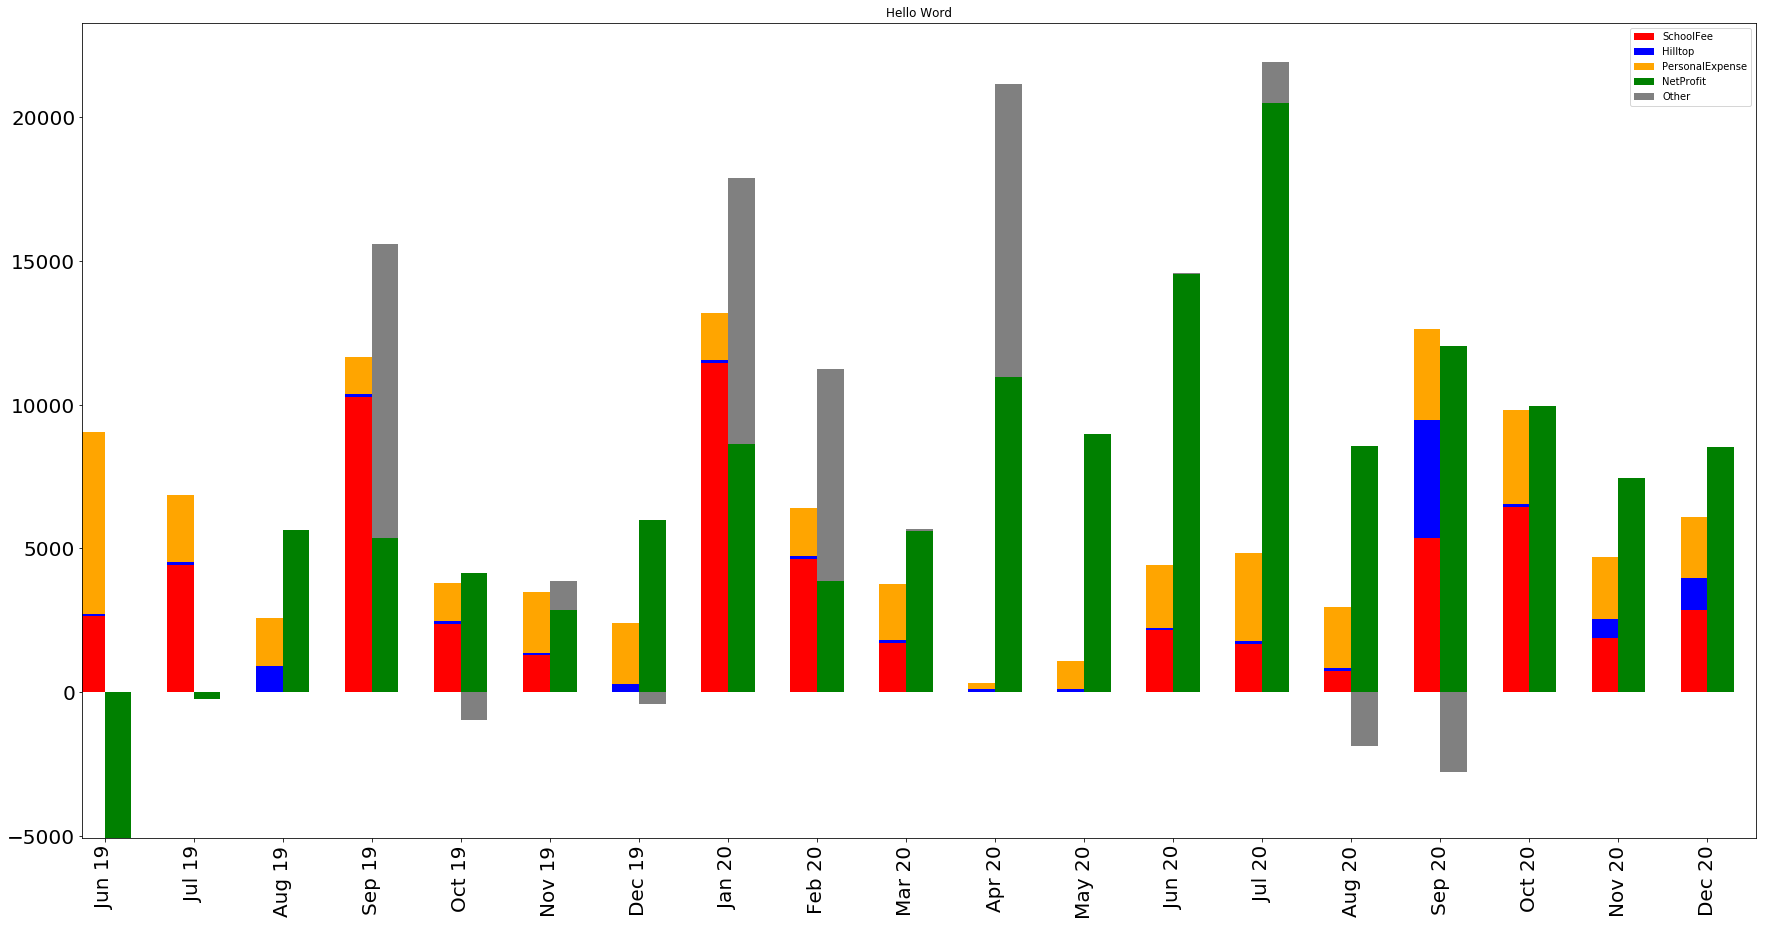

In [64]:
from matplotlib.pyplot import figure

dfBar=pd.DataFrame()
dfBar['NetProfit'] = dfOut['NetProfit']
dfBar['PersonalExpense'] = abs(dfOut['PersonalExpense']) + dfOut['RegularPayment']
dfBar['Hilltop'] = abs(dfOut['Hilltop'])
dfBar['SchoolFee'] = abs(dfOut['SchoolFee'])
dfBar['Other'] = dfOut['Other']
dfBar.index = dfBar.index.strftime('%b %y')

ax = dfBar[['SchoolFee','Hilltop','PersonalExpense']].plot.bar(stacked=True, position=1, width=.3, color=['red','blue','orange'])
dfBar[['NetProfit','Other']].plot.bar(stacked=True,ax=ax, position=0, width=.3, color=['green','grey'],figsize=(30,15),fontsize=20)


In [54]:
dfBar.index.strftime('%b %y')

Index(['Jun 19', 'Jul 19', 'Aug 19', 'Sep 19', 'Oct 19', 'Nov 19', 'Dec 19',
       'Jan 20', 'Feb 20', 'Mar 20', 'Apr 20', 'May 20', 'Jun 20', 'Jul 20',
       'Aug 20', 'Sep 20', 'Oct 20', 'Nov 20', 'Dec 20'],
      dtype='object')